In [1]:
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
import hdbscan
import datetime
import seaborn as sns
import sklearn

In [2]:
orders = pd.read_csv('Orders_Table.csv',sep=';').drop(columns = 'Unnamed: 0')

In [3]:
orders.columns

Index(['Order Id', 'Order Item Cardprod Id', 'Order Customer Id',
       'Order Department Id', 'Market', 'Order City', 'Order Country',
       'Order Region', 'Order State', 'Order Status', 'Order Zipcode',
       'order date (DateOrders)', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Id', 'Order Item Quantity',
       'Sales', 'Order Item Total', 'Order Profit', 'Type',
       'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Delivery Status', 'Late Delivery Risk'],
      dtype='object')

<AxesSubplot:>

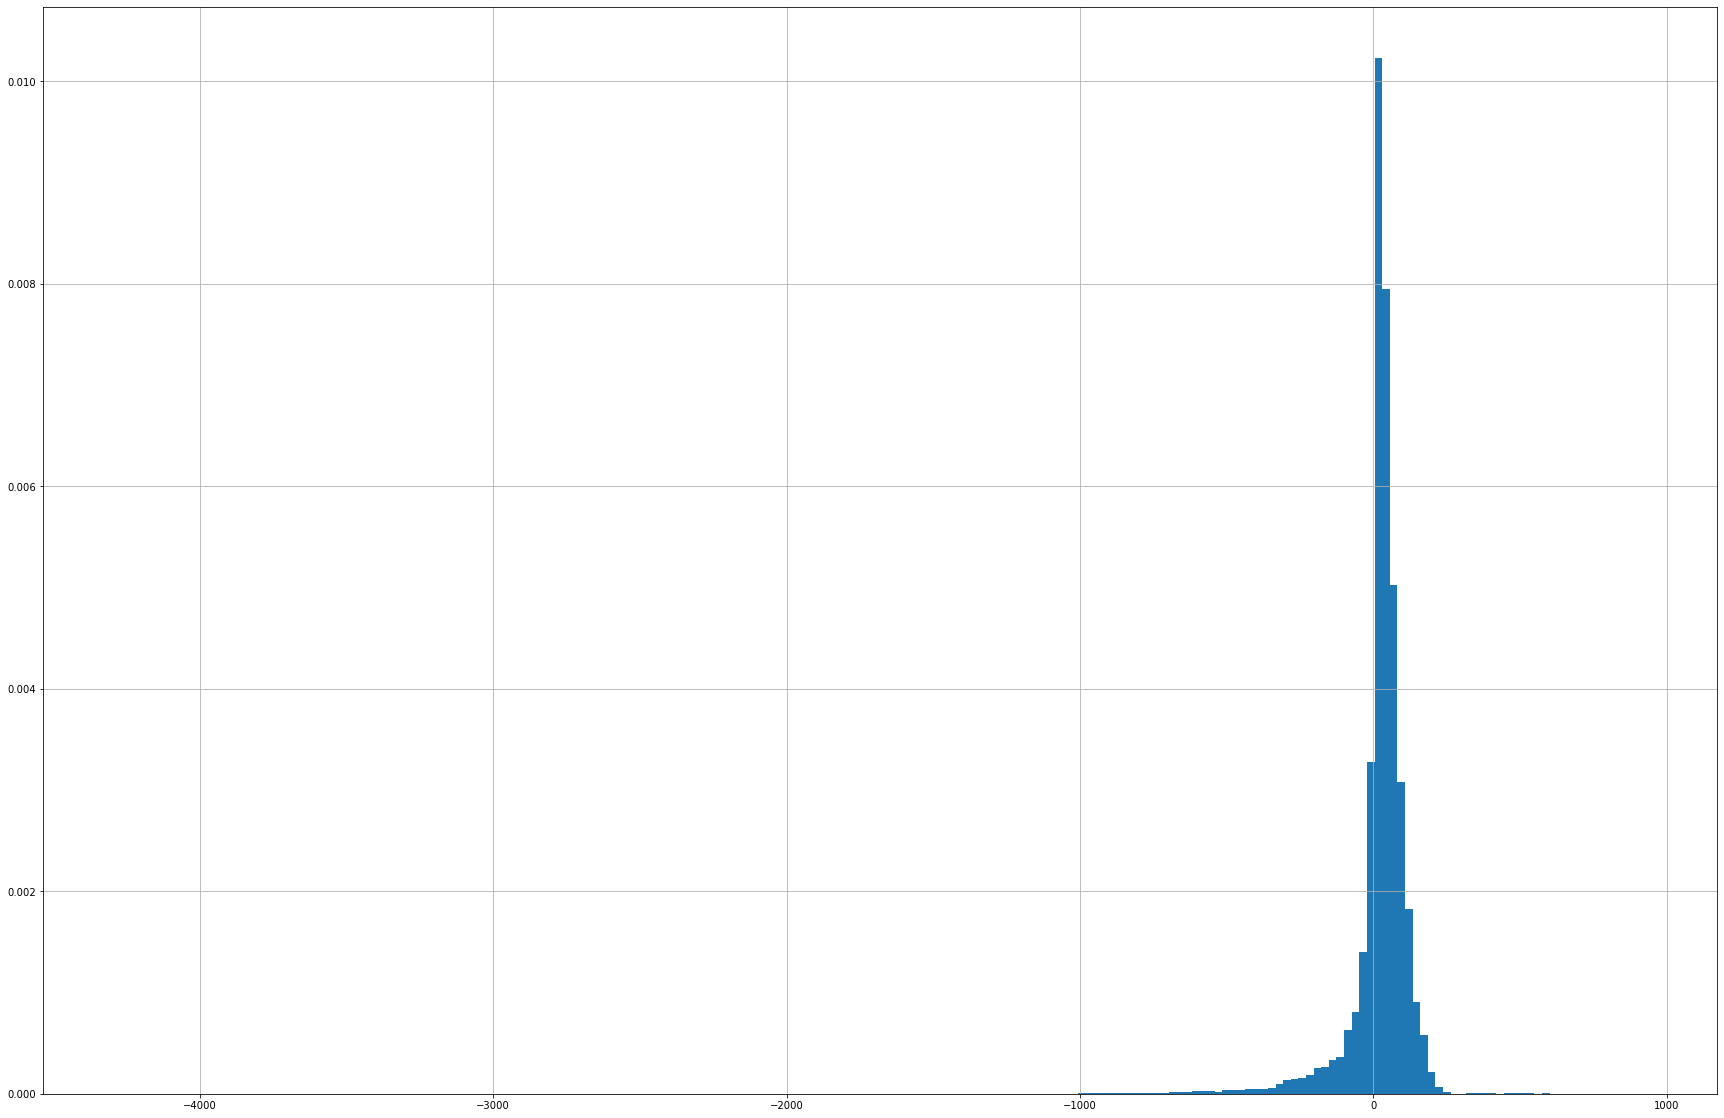

In [4]:
orders['Order Profit'].hist(bins=200, density = True, figsize = (30,20))

## Par client type

In [5]:
customer = pd.read_csv('Customer_Code.csv', sep=';')

In [6]:
customer.columns

Index(['Customer Id', 'Customer City', 'Customer Country', 'Customer Email',
       'Customer Fname', 'Customer Lname', 'Customer Password',
       'Customer Segment', 'Customer State', 'Customer Street',
       'Customer Zipcode'],
      dtype='object')

In [7]:
dico_customer = dict(zip(customer['Customer Id'], customer['Customer Segment']))

In [8]:
orders['Customer Segment'] = orders['Order Customer Id'].map(dico_customer)

Consumer 22.175390057254184
Home Office 21.43735929467564
Corporate 21.94920442984052


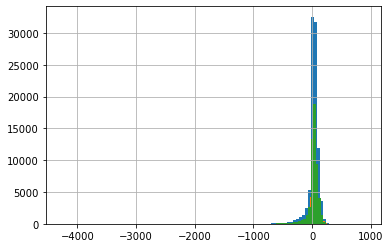

In [9]:
list_seg = np.array(orders['Customer Segment'].unique())
for seg in list_seg:
    orders[orders['Customer Segment'] == seg]['Order Profit'].hist(bins=100)
    print(seg, orders[orders['Customer Segment'] == seg]['Order Profit'].mean() )

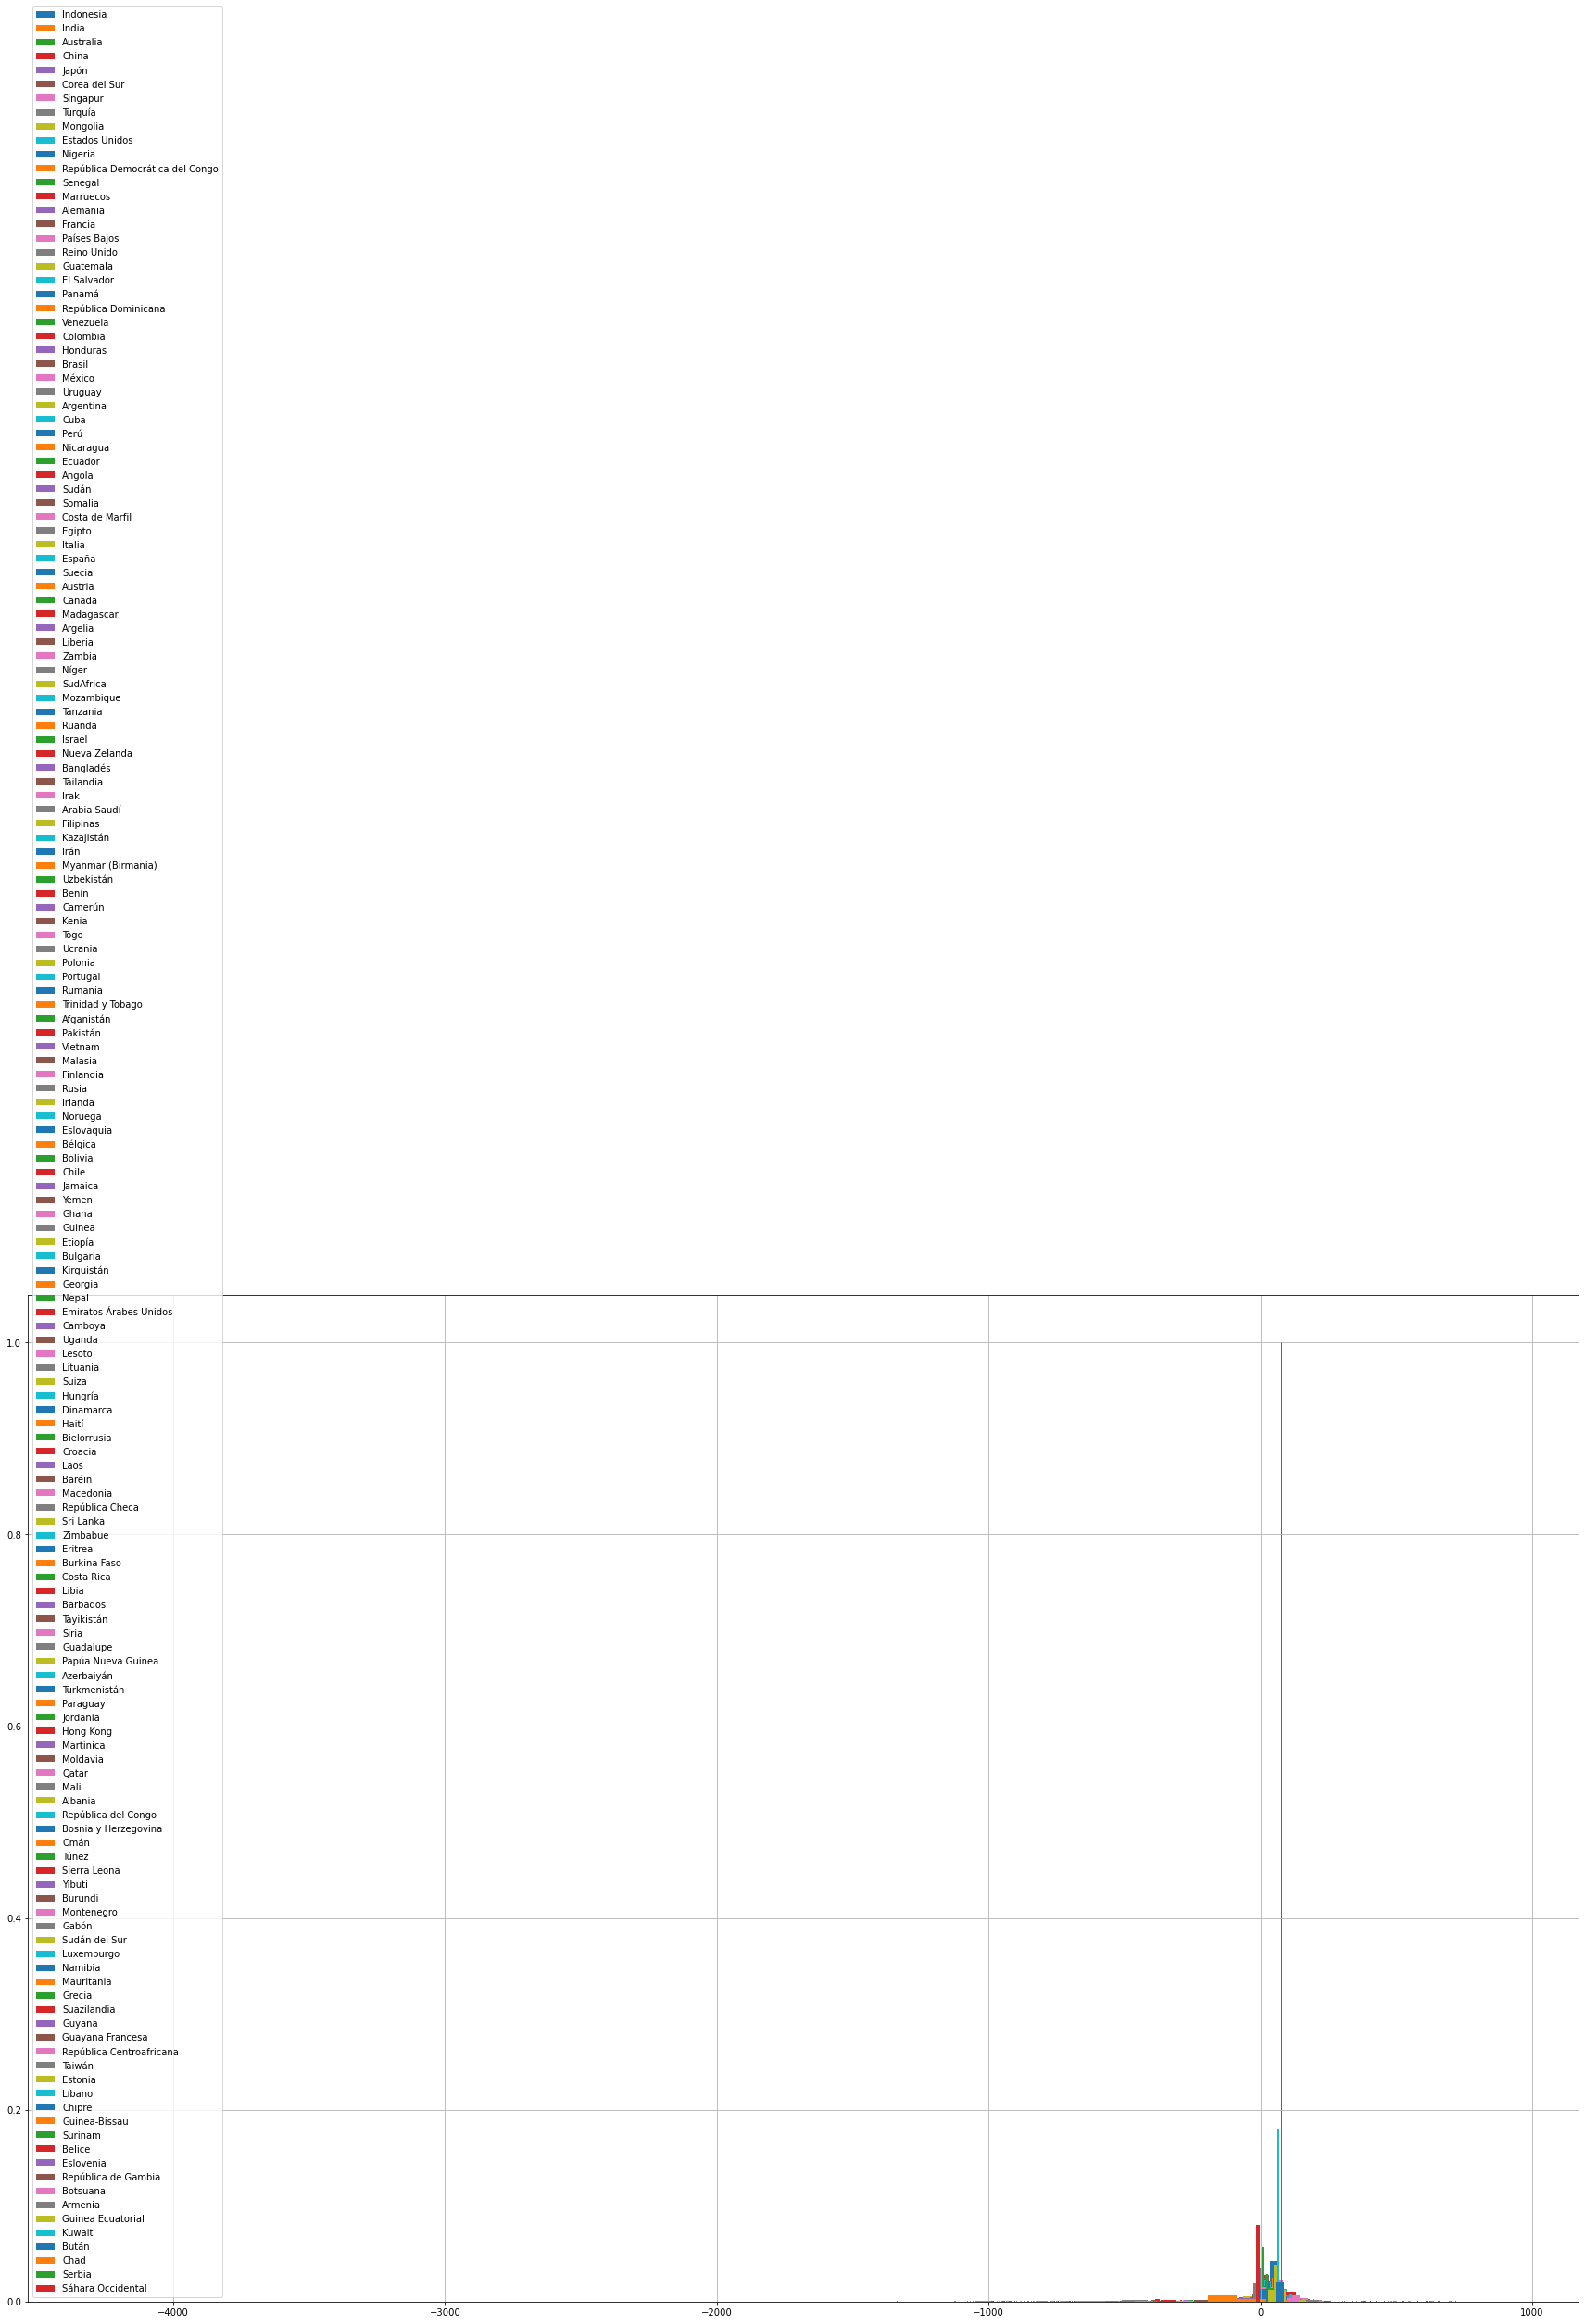

In [4]:
def distrib(col):
    col_values = np.array(orders[col].unique())
    for value in col_values:
        orders[orders[col] == value]['Order Profit'].hist(bins=1+len(orders[orders[col] == value])//2, density = True, figsize = (30,20), label = value)
    plt.legend()
        
distrib('Order Country')

In [20]:
orders.groupby('Order Country').sum()['Order Profit'].sort_values()

Order Country
Guinea-Bissau            -1448.720008
Taiwán                   -1374.540018
Ruanda                    -330.020066
Bosnia y Herzegovina      -327.380032
Mongolia                  -286.229951
                            ...      
Brasil                  186713.640355
Alemania                194827.080381
México                  303278.370637
Francia                 327828.580099
Estados Unidos          540413.070422
Name: Order Profit, Length: 164, dtype: float64

In [8]:
orders.groupby('Order Country').agg(lambda x : np.sum(x)/np.std(x) if np.std(x)>0 else -1)['Order Profit'].sort_values()

Order Country
Taiwán                 -7.397357
Guinea-Bissau          -7.184946
Guayana Francesa       -3.291143
Chad                   -3.116471
Sáhara Occidental      -2.785374
                        ...     
Australia            1552.497571
Brasil               1982.386777
Francia              2840.919913
México               3195.711565
Estados Unidos       5633.861658
Name: Order Profit, Length: 164, dtype: float64

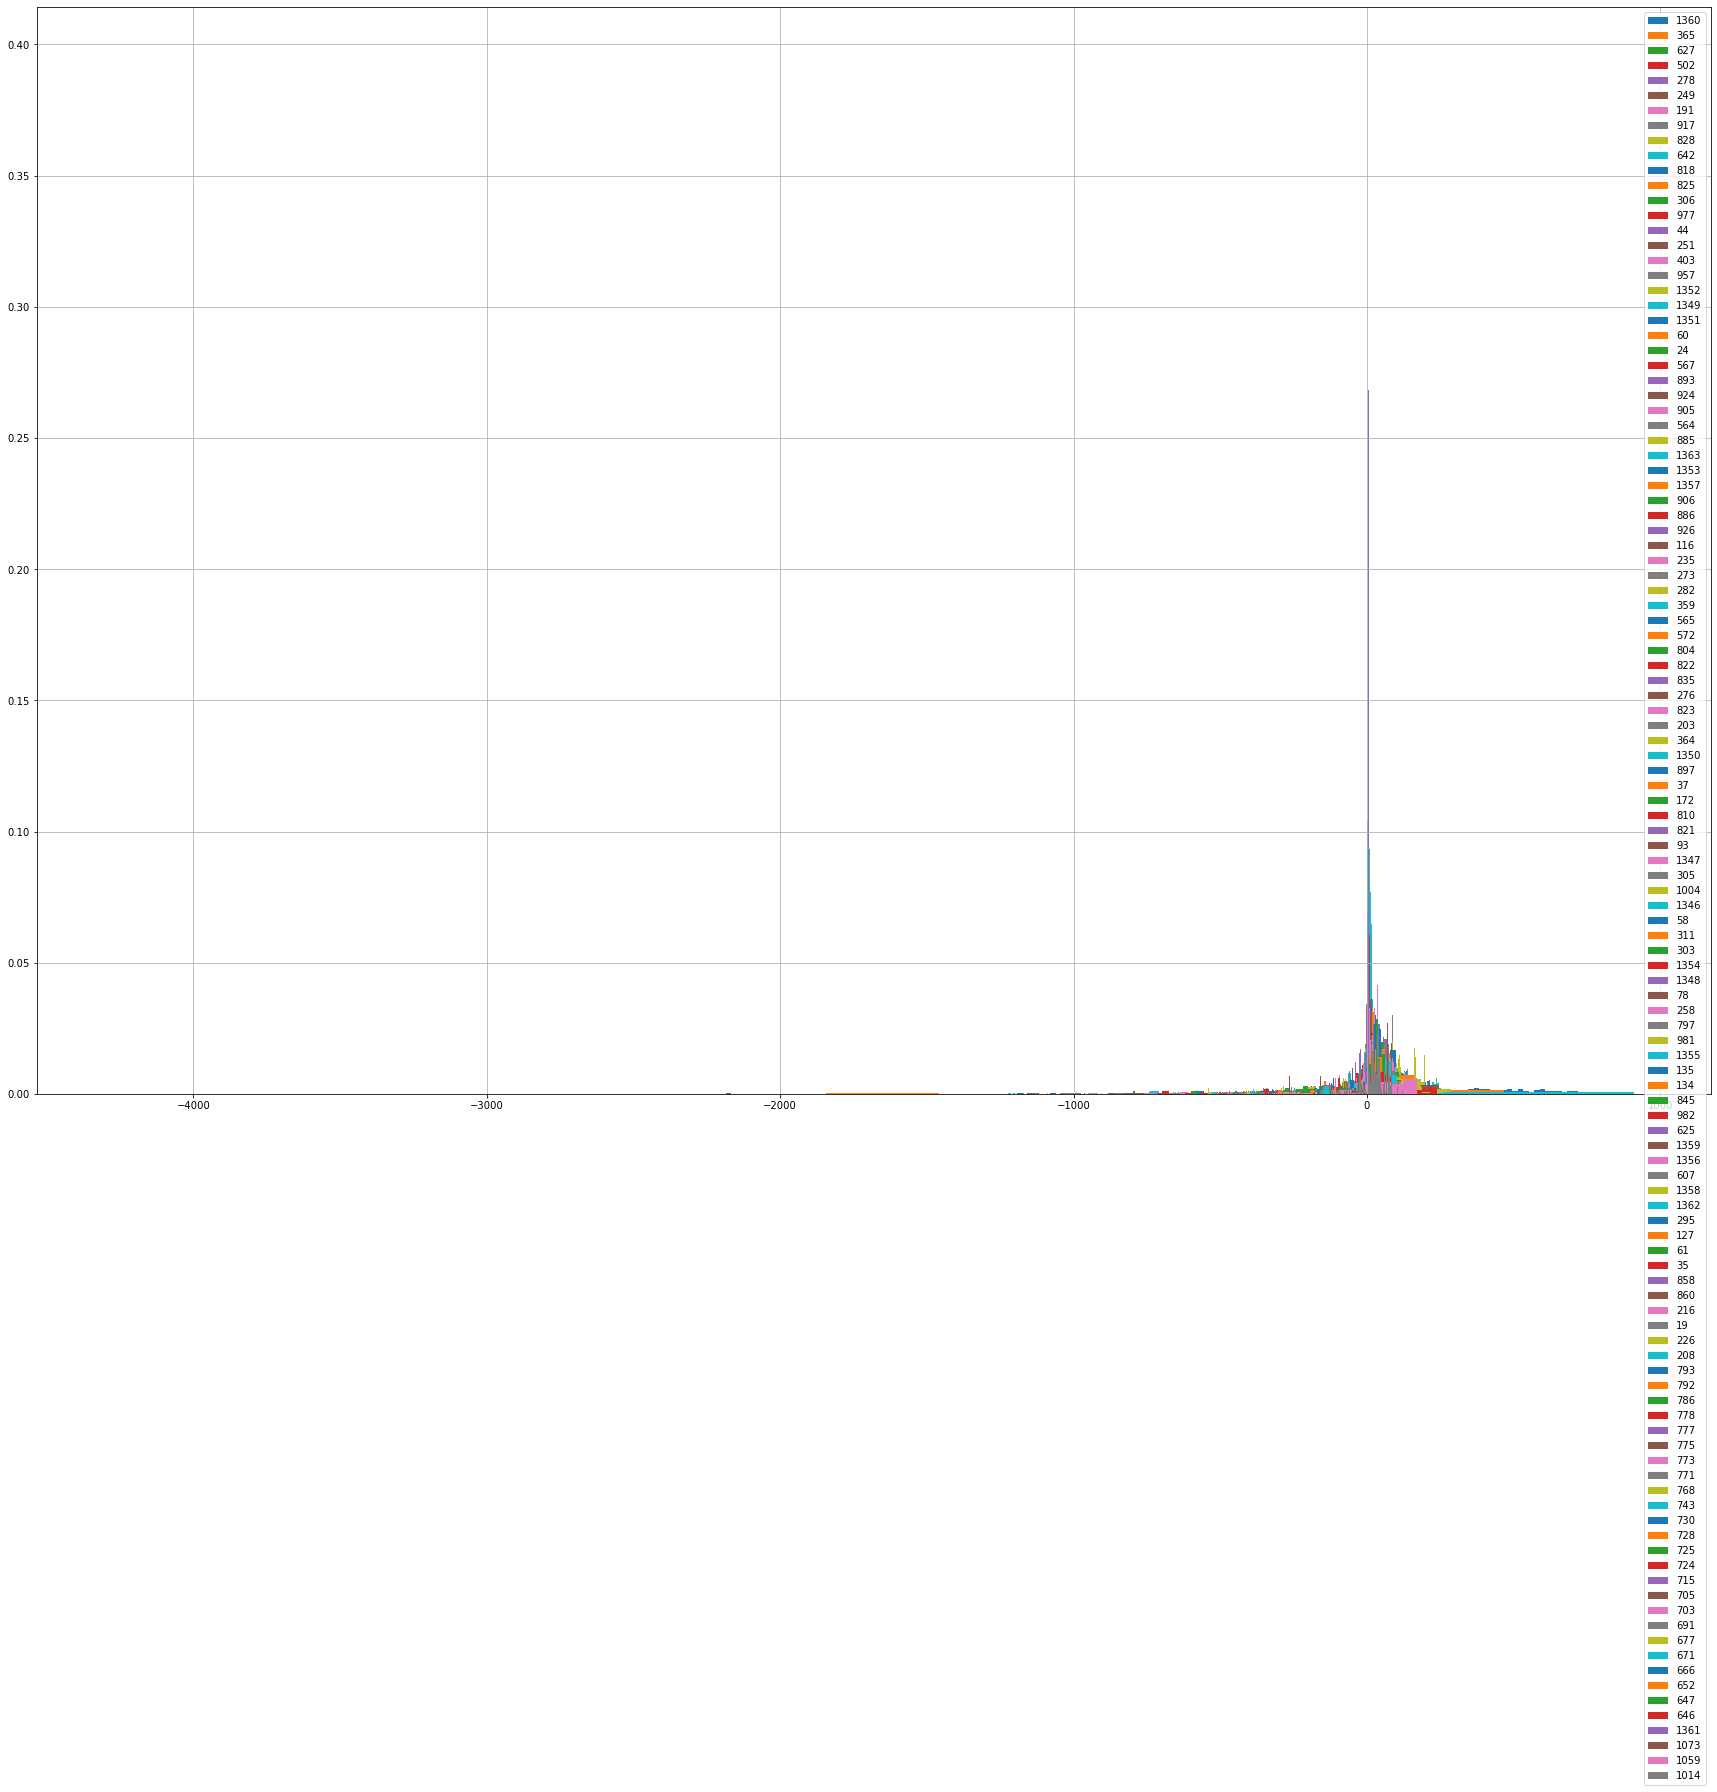

In [5]:
distrib('Order Item Cardprod Id')

In [ ]:
orders.groupby('Order Item Cardprod Id').agg(lambda x : np.mean(x)/np.std(x))['Order Profit'].sort_values()

In [27]:
orders.groupby('Order Item Cardprod Id').mean()['Order Profit'].sort_values()
#emphasize ++ prod

Order Item Cardprod Id
208     -64.341331
860     -23.268182
60      -16.956000
1348      1.416421
1361      1.702665
           ...    
306      57.947500
58       59.683103
1355     69.097128
226     119.078000
1351    157.594593
Name: Order Profit, Length: 118, dtype: float64

In [ ]:
#umap : distinguer les groupes de participants -> tenter l'interprétation |umap par produit ou par code produit
# mesurer l'efficacité risque/profit par cluster
# détecter les outliers 
#ondelettes ?
#classer les produits par sharpe  ratio plutôt que par profit moyen

In [59]:
n_neighbors = 50
min_dist = 0.1
n_components = 2
metric = 'manhattan'

def umap_function(data, target):
    reducer = umap.UMAP(
                        n_neighbors = n_neighbors,
                        min_dist = min_dist,
                        n_components = n_components,
                        metric = metric,
                        low_memory = False,
                        verbose = True,
                        random_state = 42
    )
    reducer = reducer.fit(data[[col for col in data.columns if col != target]], y = data[target])
    embedding_2d_cluster = reducer.transform(data[[col for col in data.columns if col != target]])
    embedding_2d_cluster = pd.DataFrame(embedding_2d_cluster, index = data.index, columns = ['x','y'])
    
    sns.relplot(data = embedding_2d_cluster, x='x', y='y', height = 8, aspect = 1.5, hue = data[target])
    plt.show()
    
    return embedding_2d_cluster, reducer


In [9]:
orders['order date (DateOrders)'] = pd.to_datetime(orders['order date (DateOrders)'])

ts = orders.sort_values(by = ['Order Customer Id', 'order date (DateOrders)'])
profit_sum = pd.pivot_table(
                ts,
                values = 'Order Profit',
                index = ['Order Customer Id'],
                columns = ['Market','Order Country', 'Type'],
                aggfunc = ['sum'],
                fill_value = 0
                )

profit_sum.columns = ['_'.join(map(str, col)) for col in profit_sum.columns]
profit_sum

,sum_Africa_Angola_CASH,sum_Africa_Angola_DEBIT,sum_Africa_Angola_PAYMENT,sum_Africa_Angola_TRANSFER,sum_Africa_Argelia_CASH,sum_Africa_Argelia_DEBIT,sum_Africa_Argelia_PAYMENT,sum_Africa_Argelia_TRANSFER,sum_Africa_Benín_CASH,sum_Africa_Benín_DEBIT,...,sum_Pacific Asia_Yemen_PAYMENT,sum_Pacific Asia_Yemen_TRANSFER,sum_USCA_Canada_CASH,sum_USCA_Canada_DEBIT,sum_USCA_Canada_PAYMENT,sum_USCA_Canada_TRANSFER,sum_USCA_Estados Unidos_CASH,sum_USCA_Estados Unidos_DEBIT,sum_USCA_Estados Unidos_PAYMENT,sum_USCA_Estados Unidos_TRANSFER
Order Customer Id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.739998,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-317.000015,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,201.689999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
20754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
20755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [60]:
umap_function(profit_sum.fillna(0), 'Segment')

KeyError: 'Segment'

In [62]:
profit_sum

,sum_Africa_Angola_CASH,sum_Africa_Angola_DEBIT,sum_Africa_Angola_PAYMENT,sum_Africa_Angola_TRANSFER,sum_Africa_Argelia_CASH,sum_Africa_Argelia_DEBIT,sum_Africa_Argelia_PAYMENT,sum_Africa_Argelia_TRANSFER,sum_Africa_Benín_CASH,sum_Africa_Benín_DEBIT,...,sum_Pacific Asia_Yemen_TRANSFER,sum_USCA_Canada_CASH,sum_USCA_Canada_DEBIT,sum_USCA_Canada_PAYMENT,sum_USCA_Canada_TRANSFER,sum_USCA_Estados Unidos_CASH,sum_USCA_Estados Unidos_DEBIT,sum_USCA_Estados Unidos_PAYMENT,sum_USCA_Estados Unidos_TRANSFER,Country
Order Customer Id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,73.739998,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-317.000015,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,201.689999,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,NaN
20754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,NaN
20755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,NaN


In [63]:
customer = pd.read_csv('Customer_Code.csv', sep = ';')
dico_countries = dict(zip(customer['Customer Segment'].unique(), range(len(customer['Customer Segment'].unique()))))
dico_customer = dict(zip(customer['Customer Id'], customer['Customer Segment'].map(dico_countries)))
profit_sum.drop(columns = 'Country')
profit_sum['Segment'] = profit_sum.reset_index()['Order Customer Id'].map(dico_customer)

UMAP(low_memory=False, metric='manhattan', n_neighbors=50, random_state=42, verbose=True)
Tue Mar  8 21:03:10 2022 Construct fuzzy simplicial set
Tue Mar  8 21:03:10 2022 Finding Nearest Neighbors
Tue Mar  8 21:03:10 2022 Building RP forest with 12 trees
Tue Mar  8 21:03:11 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Tue Mar  8 21:03:28 2022 Finished Nearest Neighbor Search
Tue Mar  8 21:03:29 2022 Construct embedding



Tue Mar  8 21:04:05 2022 Finished embedding


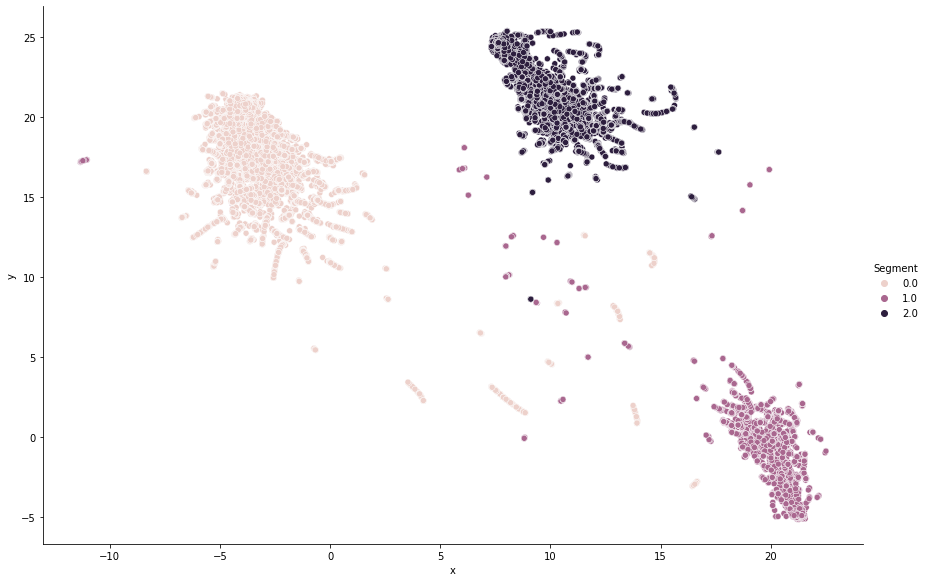

(                           x          y
 Order Customer Id                      
 1                  -1.213702  11.612680
 2                  -3.419259  17.866768
 3                  -4.991802  14.932837
 4                  20.792889  -4.258439
 5                  -3.125405  16.160915
 ...                      ...        ...
 20753              -4.549172  19.605316
 20754              -5.374083  17.105762
 20755              -5.145906  13.464210
 20756              -3.842086  20.822525
 20757               6.824306   6.510509
 
 [20652 rows x 2 columns],
 UMAP(low_memory=False, metric='manhattan', n_neighbors=50, random_state=42, verbose=True))

In [65]:
umap_function(profit_sum.fillna(0), 'Segment')

In [83]:
n_neighbors = 50
min_dist = 0.1
n_components = 2
metric = 'manhattan'

def umap_function(data):
    reducer = umap.UMAP(
                        n_neighbors = n_neighbors,
                        min_dist = min_dist,
                        n_components = n_components,
                        metric = metric,
                        low_memory = False,
                        verbose = True,
                        random_state = 42
    )
    reducer = reducer.fit(data)
    embedding_2d_cluster = reducer.transform(data)
    embedding_2d_cluster = pd.DataFrame(embedding_2d_cluster, index = data.index, columns = ['x','y'])
    
    sns.relplot(data = embedding_2d_cluster, x='x', y='y', height = 8, aspect = 1.5)
    plt.show()
    
    return embedding_2d_cluster, reducer


In [76]:
def pos_neg_split(data_to_split):
    for col in data_to_split.columns:
        
        table_pos = data_to_split[data_to_split[col] > 0][col]
        table_neg = data_to_split[data_to_split[col] < 0][col]
                                   
        if len(table_pos)>1:
            mean_pos = table_pos.fillna(0).mean()
            data_to_split[col+'positive_mean_'+str(int(mean_pos))] = data_to_split[col].apply(lambda x : x if x> 0 else 0)
                                   
        if len(table_neg)>1:
            mean_neg = table_neg.fillna(0).mean()
            data_to_split[col+'negative_mean_'+str(int(mean_neg))] = data_to_split[col].apply(lambda x : x if x<= 0 else 0)

        
    col_quant = [col for col in data_to_split.columns if ('positive' in col) or  ('negative' in col)]
    data_split = data_to_split[col_quant]
    
    return data_split
        

In [80]:
orders['order date (DateOrders)'] = pd.to_datetime(orders['order date (DateOrders)'])

ts = orders.sort_values(by = ['Order Customer Id', 'order date (DateOrders)'])
profit_sum = pd.pivot_table(
                ts,
                values = 'Order Profit',
                index = ['Order Customer Id'],
                columns = ['Market','Order Country', 'Type'],
                aggfunc = ['sum'],
                fill_value = 0
                )

profit_sum.columns = ['_'.join(map(str, col)) for col in profit_sum.columns]
table_umap = pos_neg_split(profit_sum)
table_umap

,sum_Africa_Angola_CASHpositive_mean_136,sum_Africa_Angola_CASHnegative_mean_-357,sum_Africa_Angola_DEBITpositive_mean_104,sum_Africa_Angola_DEBITnegative_mean_-286,sum_Africa_Angola_PAYMENTpositive_mean_97,sum_Africa_Angola_PAYMENTnegative_mean_-314,sum_Africa_Angola_TRANSFERpositive_mean_130,sum_Africa_Angola_TRANSFERnegative_mean_-212,sum_Africa_Argelia_CASHpositive_mean_139,sum_Africa_Argelia_CASHnegative_mean_-243,...,sum_USCA_Canada_TRANSFERpositive_mean_131,sum_USCA_Canada_TRANSFERnegative_mean_-244,sum_USCA_Estados Unidos_CASHpositive_mean_135,sum_USCA_Estados Unidos_CASHnegative_mean_-180,sum_USCA_Estados Unidos_DEBITpositive_mean_150,sum_USCA_Estados Unidos_DEBITnegative_mean_-192,sum_USCA_Estados Unidos_PAYMENTpositive_mean_140,sum_USCA_Estados Unidos_PAYMENTnegative_mean_-202,sum_USCA_Estados Unidos_TRANSFERpositive_mean_143,sum_USCA_Estados Unidos_TRANSFERnegative_mean_-186
Order Customer Id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,73.739998,0.000000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,-317.000015,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,201.689999,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
20754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
20755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [92]:
table_umap.loc[:, (table_umap != 0).any(axis = 0)].sum()

sum_Africa_Angola_CASHpositive_mean_136                 1497.829995
sum_Africa_Angola_CASHnegative_mean_-357               -1431.099997
sum_Africa_Angola_DEBITpositive_mean_104                2832.760006
sum_Africa_Angola_DEBITnegative_mean_-286              -2007.949944
sum_Africa_Angola_PAYMENTpositive_mean_97               1172.480009
                                                          ...      
sum_USCA_Estados Unidos_DEBITnegative_mean_-192      -121195.799964
sum_USCA_Estados Unidos_PAYMENTpositive_mean_140      189915.600028
sum_USCA_Estados Unidos_PAYMENTnegative_mean_-202     -78529.449753
sum_USCA_Estados Unidos_TRANSFERpositive_mean_143     235458.220207
sum_USCA_Estados Unidos_TRANSFERnegative_mean_-186    -82853.159989
Length: 904, dtype: float64

UMAP(low_memory=False, metric='manhattan', n_neighbors=50, random_state=42, verbose=True)
Tue Mar  8 21:34:25 2022 Construct fuzzy simplicial set
Tue Mar  8 21:34:25 2022 Finding Nearest Neighbors
Tue Mar  8 21:34:25 2022 Building RP forest with 12 trees
Tue Mar  8 21:34:28 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Tue Mar  8 21:34:48 2022 Finished Nearest Neighbor Search
Tue Mar  8 21:34:48 2022 Construct embedding



Tue Mar  8 21:35:26 2022 Finished embedding


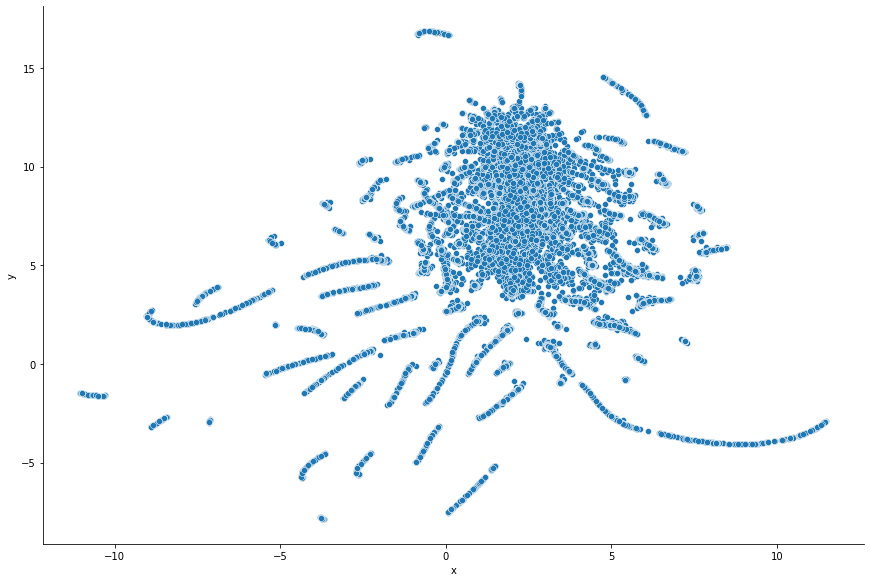

(                          x          y
 Order Customer Id                     
 1                  2.074832  -1.425240
 2                  2.177717   7.280589
 3                  4.880328   6.953102
 4                  2.727957   8.074996
 5                  1.197565   5.577556
 ...                     ...        ...
 20753             -0.061380   9.988305
 20754              5.817210   0.277798
 20755              0.585235   1.706493
 20756              2.754497  12.380942
 20757             -4.033551  -1.152720
 
 [20652 rows x 2 columns],
 UMAP(low_memory=False, metric='manhattan', n_neighbors=50, random_state=42, verbose=True))

In [93]:
umap_function(table_umap.loc[:, (table_umap != 0).any(axis = 0)].fillna(0))

In [81]:
orders = pd.read_csv('Orders_Table.csv',sep=';').drop(columns = 'Unnamed: 0')
customer = pd.read_csv('Customer_Code.csv', sep=';')
dico_customer = dict(zip(customer['Customer Id'], customer['Customer Segment']))
orders['Customer Segment'] = orders['Order Customer Id'].map(dico_customer)

orders['order date (DateOrders)'] = pd.to_datetime(orders['order date (DateOrders)'])
product_id = pd.read_csv('Product_Id.csv',sep = ';')
category_id = pd.read_csv('Category_Id.csv', sep = ';')

dico_product = dict(zip(category_id['Category Id'], category_id['Category Name']))
dico_category = dict(zip(category_id['Category Name'].unique(), range(len(category_id['Category Name'].unique()))))

product_id['Category Name'] = product_id['Product Category Id'].map(dico_product)
product_id['Category Name Num'] = product_id['Category Name'].map(dico_category)

dico_product_class = dict(zip(product_id['Product Card Id'], product_id['Category Name']))

orders['Product Class'] = orders['Order Item Cardprod Id'].map(dico_product_class)
orders['PnL'] = orders['Order Profit'].apply(lambda x : 'Profit' if x >= 0 else 'Loss')
orders['Abs Profit'] = orders['Order Profit'].abs()

ts = orders.sort_values(by = ['Order Customer Id', 'order date (DateOrders)'])
profit_sum = pd.pivot_table(
                ts,
                values = 'Abs Profit',
                index = ['Order Customer Id'],
                columns = ['Customer Segment', 'Product Class', 'PnL'],
                aggfunc = ['sum'],
                fill_value = 0
                )

profit_sum.columns = ['_'.join(map(str, col)) for col in profit_sum.columns]
profit_sum_normed = profit_sum.div(profit_sum.sum(axis=1), axis=0).loc[:, (profit_sum != 0).any(axis = 0)]
profit_sum_normed 

,sum_Consumer_Accessories_Loss,sum_Consumer_Accessories_Profit,sum_Consumer_As Seen on TV!_Loss,sum_Consumer_As Seen on TV!_Profit,sum_Consumer_Baby _Loss,sum_Consumer_Baby _Profit,sum_Consumer_Baseball & Softball_Loss,sum_Consumer_Baseball & Softball_Profit,sum_Consumer_Basketball_Loss,sum_Consumer_Basketball_Profit,...,sum_Home Office_Video Games_Loss,sum_Home Office_Video Games_Profit,sum_Home Office_Water Sports_Loss,sum_Home Office_Water Sports_Profit,sum_Home Office_Women's Apparel_Loss,sum_Home Office_Women's Apparel_Profit,sum_Home Office_Women's Clothing_Loss,sum_Home Office_Women's Clothing_Profit,sum_Home Office_Women's Golf Clubs_Loss,sum_Home Office_Women's Golf Clubs_Profit
Order Customer Id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.031739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20754,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20755,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


UMAP(low_memory=False, n_neighbors=100, random_state=42, verbose=True)
Wed Mar  9 00:06:04 2022 Construct fuzzy simplicial set
Wed Mar  9 00:06:04 2022 Finding Nearest Neighbors
Wed Mar  9 00:06:04 2022 Building RP forest with 12 trees
Wed Mar  9 00:06:05 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Wed Mar  9 00:06:39 2022 Finished Nearest Neighbor Search
Wed Mar  9 00:06:39 2022 Construct embedding



Wed Mar  9 00:09:28 2022 Finished embedding


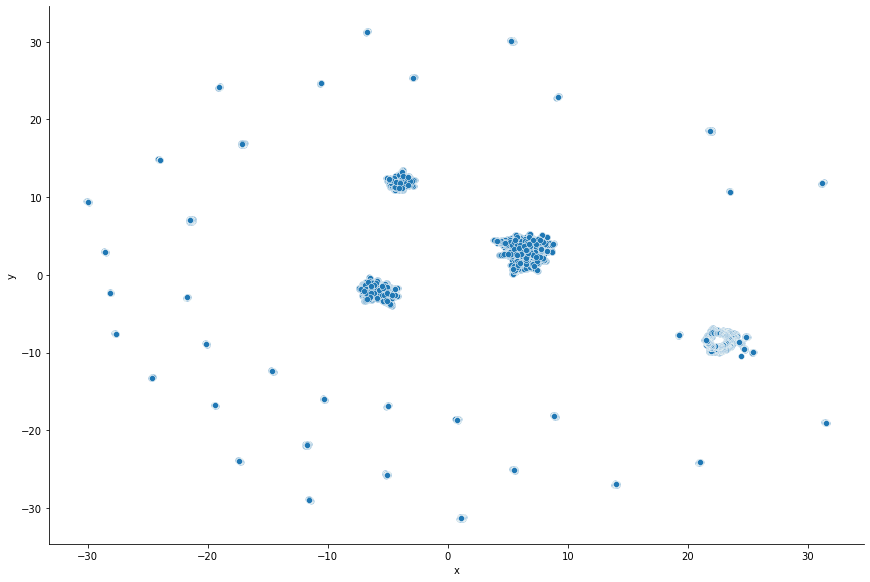

In [83]:
n_neighbors = 100
min_dist = 0.1
n_components = 2
metric = 'euclidean'

def umap_function(data):
    reducer = umap.UMAP(
                        n_neighbors = n_neighbors,
                        min_dist = min_dist,
                        n_components = n_components,
                        metric = metric,
                        low_memory = False,
                        verbose = True,
                        random_state = 42
    )
    reducer = reducer.fit(data)
    embedding_2d_cluster = reducer.transform(data)
    embedding_2d_cluster = pd.DataFrame(embedding_2d_cluster, index = data.index, columns = ['x','y'])
    
    sns.relplot(data = embedding_2d_cluster, x='x', y='y', height = 8, aspect = 1.5)
    plt.show()
    
    return embedding_2d_cluster, reducer

embedding_2d_cluster, reducer = umap_function(profit_sum_normed.fillna(0))

In [84]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=100, min_cluster_size=50).fit_predict(embedding_2d_cluster)

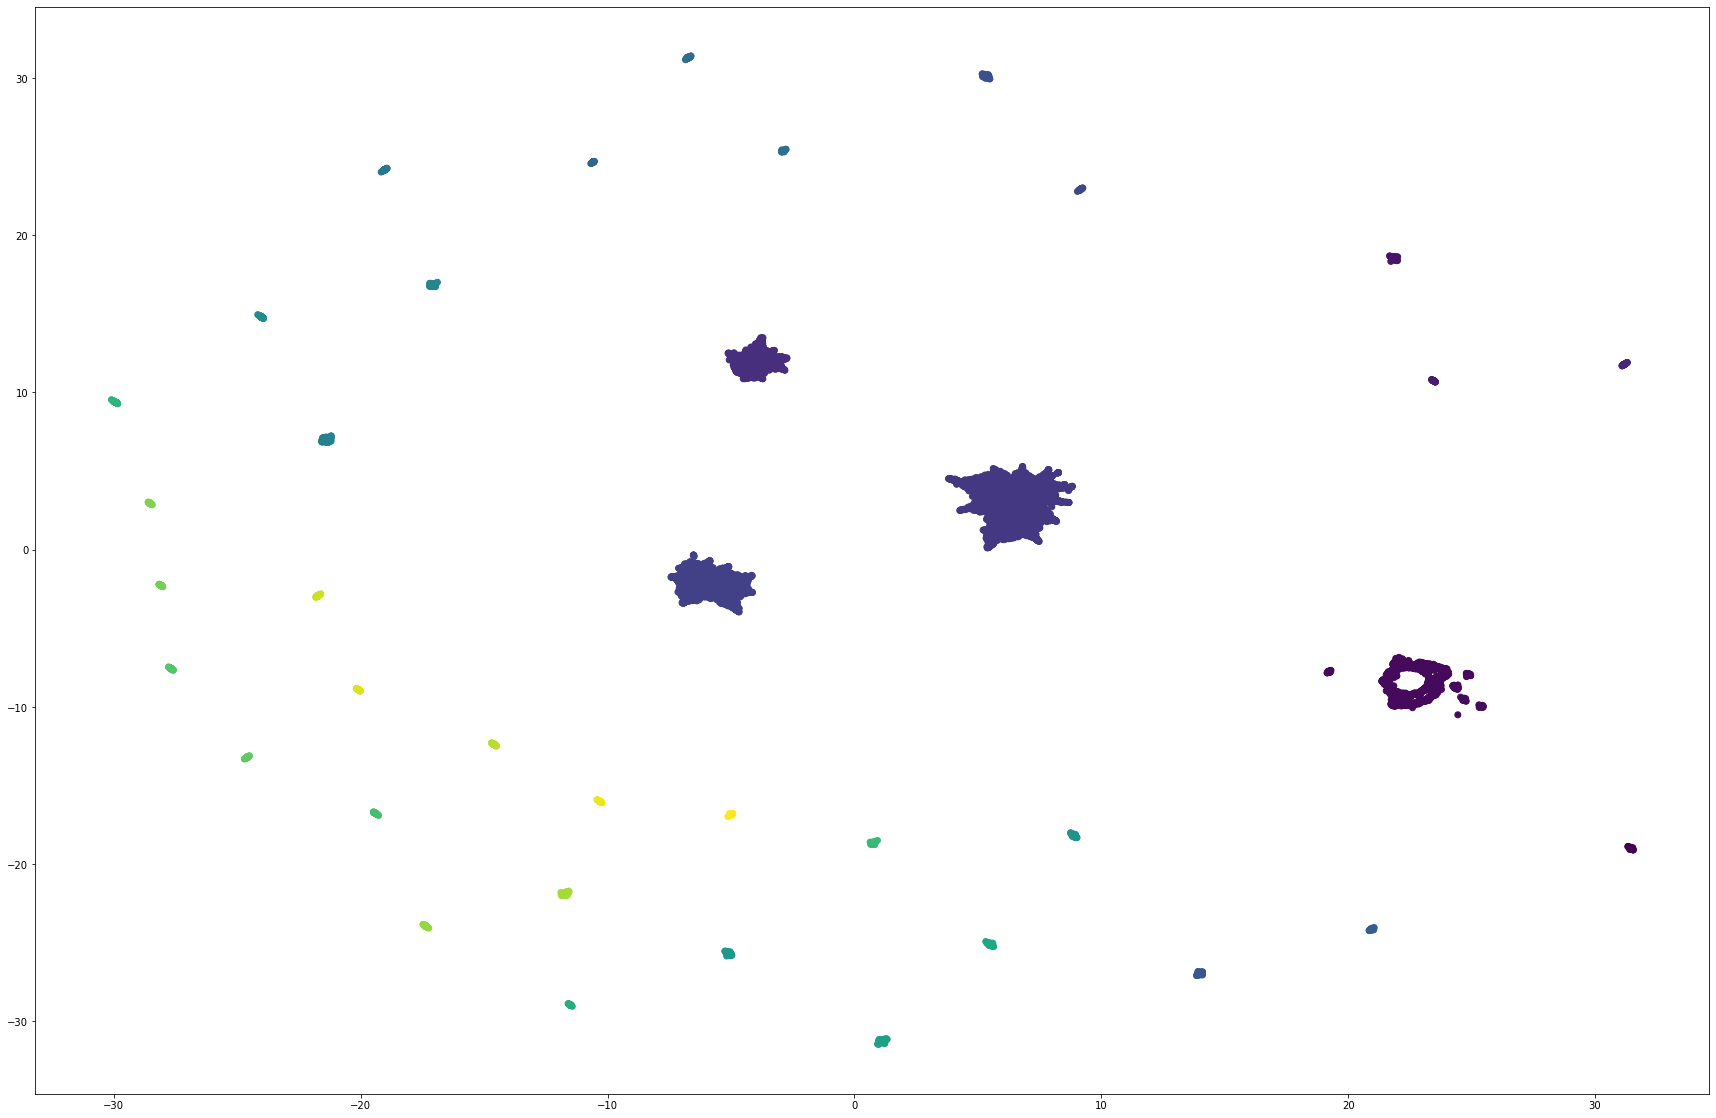

In [85]:
plt.figure(figsize = (30,20))
plt.scatter(embedding_2d_cluster['x'], embedding_2d_cluster['y'], c = hdbscan_labels)

In [86]:
plot_xy = embedding_2d_cluster.copy()
plot_xy['label'] = hdbscan_labels
plot_xy.groupby('label').count().x.sort_values()

label
12     101
30     101
3      103
23     107
14     108
8      108
29     113
37     114
28     115
27     116
36     124
26     127
24     127
33     128
35     133
13     134
11     140
15     141
31     145
18     151
34     154
0      159
4      162
25     186
20     188
22     199
32     199
19     218
17     221
10     222
2      259
9      264
21     280
16     359
5     2211
1     2820
7     3707
6     6408
Name: x, dtype: int64

In [ ]:
orders.groupby('order date (DateOrders)').sum()['Order Profit']

In [ ]:
#see the impact of good clusters on the profit ?